<h1>Investigating Tweet Timelines Using Interactive Bokeh Scatterplots</h1>
<p>For this lesson we will extend the work done in <a href="https://cvw.cac.cornell.edu/PyDataSci1/tweets_retweets">Part 1 for cumulative timeline plots</a> of individual tweet/retweet lifetimes using Bokeh to create powerful interactive plots.</p>

<p>First, we will replay the initial steps involved to import and prepare our data for plotting and we will also show additional ways to generate more complex cumulative timeline plots using matplotlib so we can better understand both the advantages and limitations of this approach before moving to Bokeh.</p>

<h2>About the Data</h2>
<p>This dataset was created using the Twitter Streaming API searching for all tweets/retweets which use the hashtag 'climatechange' during a specified time interval. The original data were collected in its native JSON format, from which we extracted a subset of features, as described <a href="https://cvw.cac.cornell.edu/PyDataSci1/filtering_twitter">in Part 1 of our CVW tutorial</a>. 
Here are some statistics for this dataset. </p>
<p>
    <ul>
        <li>Timeline Start: 2018-11-20 00:07:52</li>
        <li>Timeline End: 2018-12-05 18:38:47</li>
        <li>457294 Total Tweets</li>
        <li>319103 Retweets</li>
        <li>138191 Original Tweets</li>
        </ul>
        </p>

In [1]:
import re
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from math import exp, expm1
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io.export import export_png

<b>Import the data into a dataframe</b>

First, we will initialize our hashtag and data directory variables. Then we import the data into a Pandas dataframe and display the first five rows. 

In [2]:
# Initialize parameters
hashtag = "climatechange"
#data_dir = 'https://cvw.cac.cornell.edu/PyDataSci1/data/twitter/'
data_dir = '/data/elastic-notebook/data/cvw/twitter/'
# Import the data and display the 1st five rows
tweet_df = pd.read_csv(data_dir + 'climatechange_tweets_all.csv', parse_dates=['tweet_created_at', 'user_created_at'])
tweet_df.head()

,tweet_id,tweet_created_at,language,user_screen_name,user_created_at,user_id,followers_count,friends_count,time_zone,utc_offset,retweeted_status,retweet_id,retweet_user_screen_name,retweet_user_id,text
0,1068223635024941056,2018-11-29 19:22:15,en,JGuerreroN13,2017-06-07 20:21:48,872549171680694272,245,419,NaN,NaN,1,1068067040882233344,UNFCCC,17463923,RT @UNFCCC: Delegates from around the world ar...
1,1068223643765940226,2018-11-29 19:22:17,en,t_rustyboy1720,2017-09-23 03:53:34,911438362271031296,63,232,NaN,NaN,1,1068210734977490944,saskboy,6634632,RT @saskboy: I think we most often hear the wo...
2,1068223645330432001,2018-11-29 19:22:18,en,MissCJWright,2009-03-15 16:24:32,24544855,1383,4585,NaN,NaN,1,1068223231264505857,EcoSenseNow,1392956425,"RT @EcoSenseNow: It mat not be obvious, but Ei..."
3,1068223649222664194,2018-11-29 19:22:19,en,al_f,2009-07-17 00:05:50,57490401,333,377,NaN,NaN,1,1068181567510626310,ClimateComms,362642209,RT @ClimateComms: Most Americans now see #clim...
4,1068223660299677696,2018-11-29 19:22:21,en,Hawknana_,2013-12-21 03:16:04,2255917724,1751,3409,NaN,NaN,1,1068187254768590848,PortlandBEM,18030823,RT @PortlandBEM: Last week's federal climate c...


Next, we will extract the retweets into a separate dataframe.

In [3]:
retweet_df = tweet_df[tweet_df.retweeted_status == 1]

We need the extract the top retweeted tweets (topretweets), the most frequently retweeted Twitter accounts (topretweeted), and the Twitter accounts which retweeted the most, using the groupby command. For this lesson, we are most interested in the first dataset, topretweets, but it may be of interest to know how to generate the other two, as well. In all cases, we can accomplish this using the <a href="https://cvw.cac.cornell.edu/PyDataSci1/groupby">groupby operation on Pandas DataFrames</a>.

In [4]:
num_top_retweets = retweet_df.groupby('retweet_id').size().sort_values(ascending=False).reset_index()
num_top_retweeted = retweet_df.groupby('retweet_user_screen_name').size().sort_values(ascending=False).reset_index()
num_top_retweeters = retweet_df[retweet_df.retweeted_status != 0].groupby('user_screen_name').size().sort_values(ascending=False).reset_index()

The feature we are interested in for this lesson is those tweets which were retweeted the most in the dataset, including their retweet count. Let's look at the first 5 rows of the top retweeted tweets.

In [5]:
num_top_retweets.head()

,retweet_id,0
0,1066155330986541058,8923
1,1067149009867878400,3316
2,1065274149461987328,3108
3,1069278755041001472,2885
4,1069686443109466113,2509


The column named '0' contains the retweet counts. Let's rename that column.

In [6]:
num_top_retweets = num_top_retweets.rename(columns={0:'retweet_count'})

In [7]:
num_top_retweets.head()

,retweet_id,retweet_count
0,1066155330986541058,8923
1,1067149009867878400,3316
2,1065274149461987328,3108
3,1069278755041001472,2885
4,1069686443109466113,2509


We can similarly rename the columns for the other dataframes just created.

In [8]:
num_top_retweeters = num_top_retweeters.rename(columns={0:'retweet_count'})
num_top_retweeted = num_top_retweeted.rename(columns={0:'retweet_count'})

<b>Generate 'Cumulative Timelines' of Top Tweet Lifespans Scaled by Followers Count</b>

We ended Part 1 with an example of how to create 'cumulative timelines' of the tweets which were retweeted the most in the dataset, which we presented with scatterplots, of cumulative retweet count over time.  We now want to augment that by adding a third variable to the data visualization, namely the 'followers_count' attribute of each retweet.  Since the followers_count can vary greatly among users, we'll want to create a new data column that both scales the counts to make the data amenable for plotting, as well as clip the maximum value in that column so that the plots are not dominated by a few outliers.  In the code cell below, this is accomplished by applying a lambda function to followers_count data:

<pre>
top_retweets['followers_count_scaled'] = \
   top_retweets['followers_count'].apply(lambda x: np.clip(x/1000, 0., 3000.))
</pre>

Let's restrict our plots to only the top 3 rows in num_top_retweets.

<b>Generate Combined Cumulative Timelines of Top Tweet Lifespans Scaled by Followers Count</b>

The previous plot provides some additional insight into the role certain users play in influencing the lifetime of a tweet. However, the scale factor for some points is so large it can obscure the underlying path. To solve this problem, we will overlay a second plot similar to the first but with a different color and constant smaller scale. We will also reduce the alpha channel values for the underlying plot to help reveal additional information. 

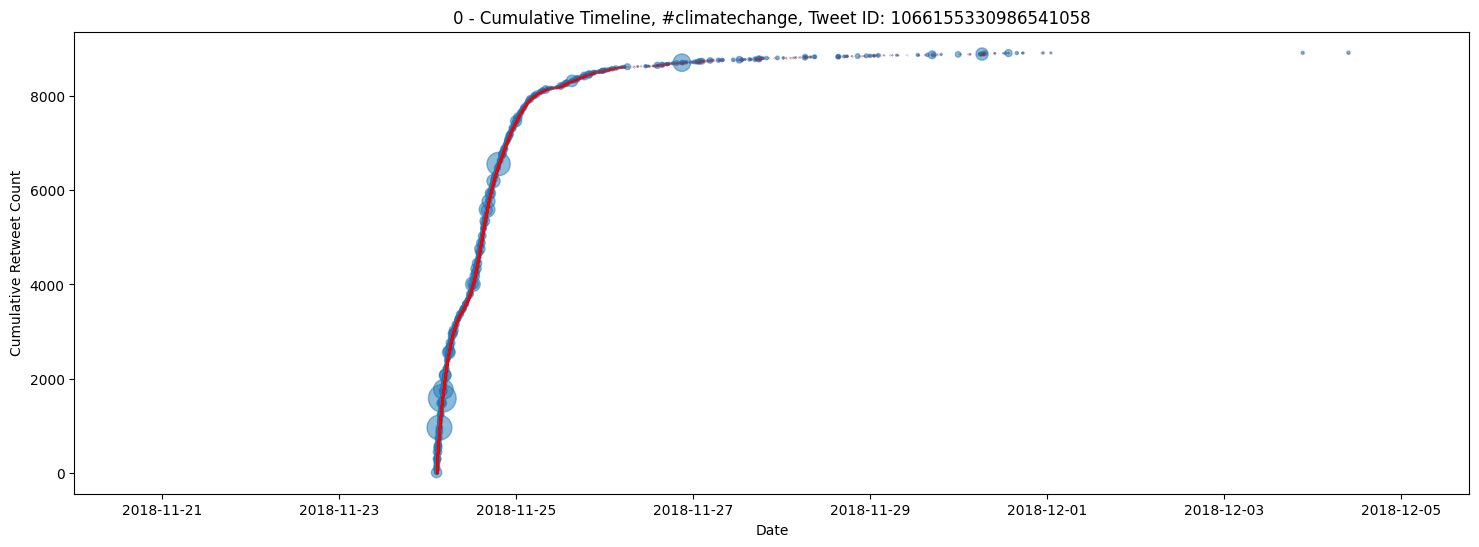

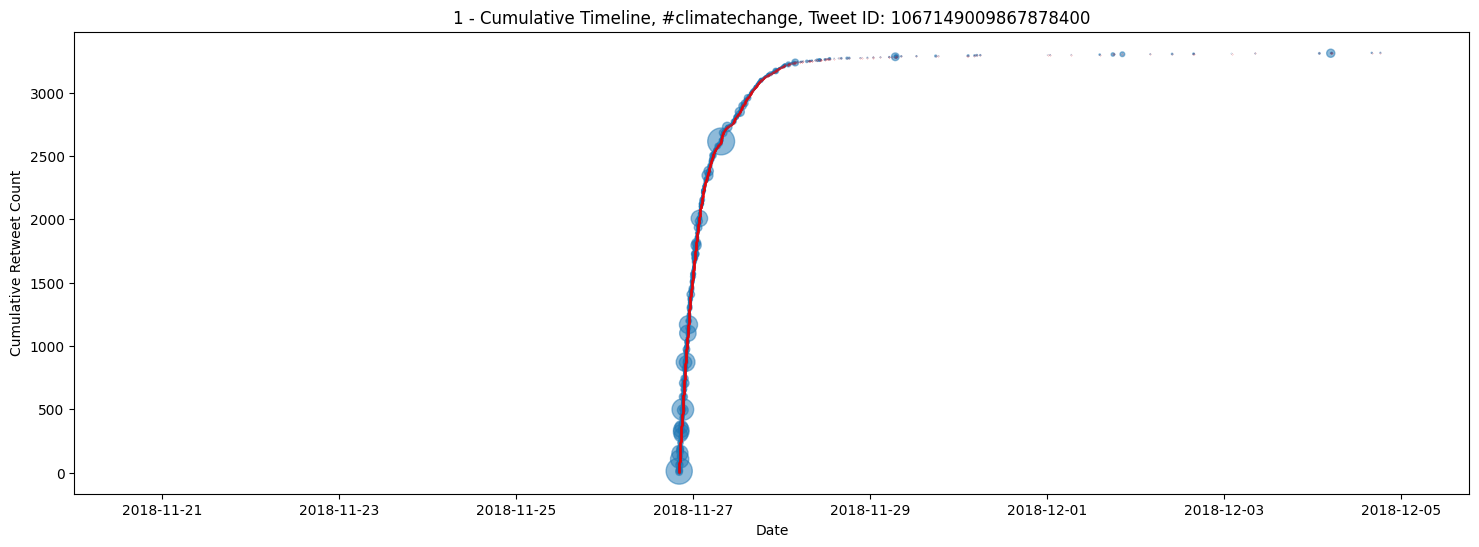

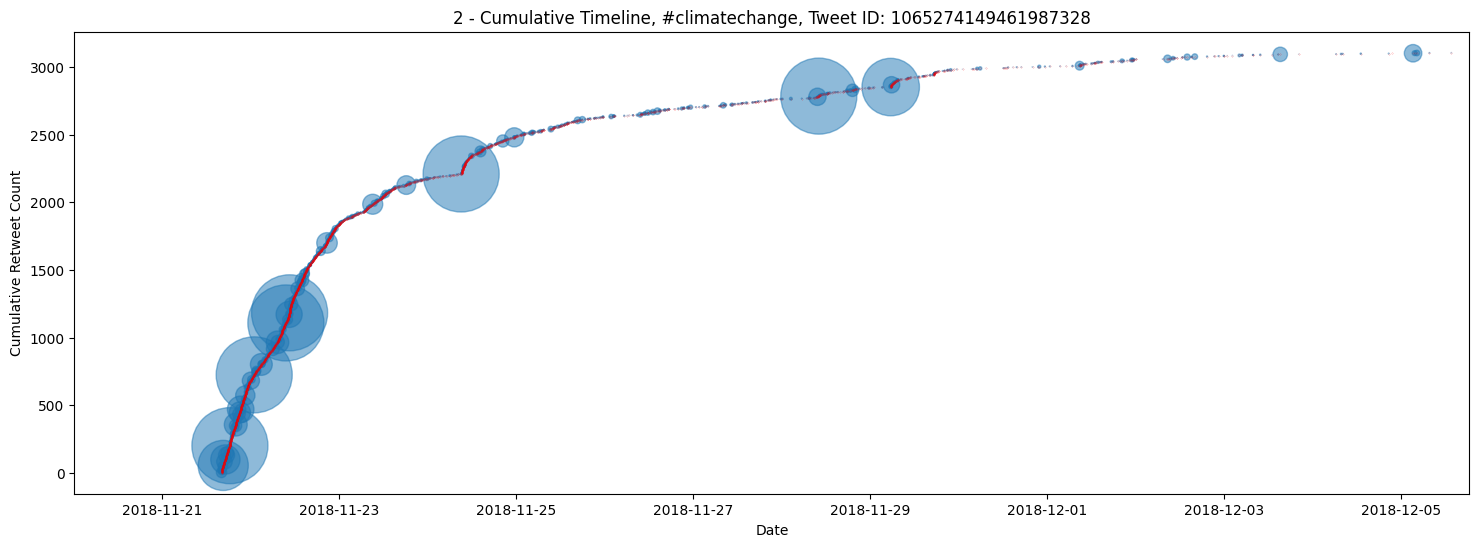

In [9]:
# Set our start and end range
start_tweet = 0
num_tweets = 3

# Loop through topretweets
for top in range(start_tweet, start_tweet + num_tweets):
    
    # Get all retweets for tweetid
    tweetid = num_top_retweets.iloc[top].retweet_id
    top_retweets = retweet_df[retweet_df.retweet_id==tweetid].\
        sort_values('tweet_created_at').reset_index()
    
    top_retweets['followers_count_scaled'] = top_retweets['followers_count'].apply(lambda x: np.clip(x/1000, 0., 3000.))

    plt.figure(figsize=(18,6))
    plt.scatter(top_retweets.tweet_created_at, top_retweets.index, s=top_retweets.followers_count_scaled, alpha=0.5)
    plt.plot(top_retweets.tweet_created_at, top_retweets.index, 'ro', markersize=0.1)
    plt.xlim(tweet_df.tweet_created_at.min(), tweet_df.tweet_created_at.max())
    plt.xlabel('Date')
    plt.ylabel('Cumulative Retweet Count')
    plt.title(str(top) + ' - Cumulative Timeline, #' + hashtag + ', Tweet ID: ' + str(tweetid));


#start_tweet = 0
#end_tweet = 2
#for top in range(start_tweet, end_tweet):
#    
#    # Get all retweets for tweetid
#    tweetid = topretweets.iloc[top].retweet_id
#    top_retweets = climatechange_retweet_df[climatechange_retweet_df.retweet_id==tweetid].sort_values('tweet_created_at').reset_index()
#    
#    # Create a list of datesfor x axis
#    values = list(x for x in top_retweets["tweet_created_at"])
#    
#    # Create list of followers counts
#    followers_count = list(f for f in top_retweets['followers_count'])
#    followers_count_scaled = []
#    for j in range(len(followers_count)):
#        if followers_count[j] > 1000000:
#            followers_count_scaled.append(3000)
#        else:                
#            followers_count_scaled.append(followers_count[j]/1000)
#    
#    plt.figure(figsize=(18,6))
#    plt.scatter(top_retweets.tweet_created_at, top_retweets.index, s=followers_count_scaled, alpha=0.6)
#    plt.plot(top_retweets.tweet_created_at, top_retweets.index, 'ro', markersize=0.1)
#    tl = len(top_retweets)-1
#    plt.xlim([datetime.datetime(values[0].year, values[0].month, values[0].day), datetime.datetime(values[tl].year, values[tl].month, values[tl].day, values[tl].hour)])
#    plt.xlabel('Date')
#    plt.ylabel('Cumulative Retweet Count')
#    plt.title(str(top) + ' - Cumulative Timeline, #' + hashtag + ' Set 2, Tweet ID: ' + str(tweetid))
#    plt.show()
#    plt.savefig("../pages/images/" + str(top) + "_" + hashtag + "_tweet_" + str(tweetid) + "_combined_scatter_v1_nov20_to_dec5_2018.png")
#    plt.close()


<b>Generate Interactive Bokeh Plots in HTML</b>

While the above methods can be very useful in gaining insight into a tweet's retweet lifespan, there may be value in knowing exactly who tweeted which retweet at any particular moment for a specific tweet. We may also want the ability to pan and zoom through our plots and select subsets to gain additional insights. Let's see how to do this with Bokeh. 

Bokeh works by generating plots in web browsers, combining a high-level Python programming interface that generates javascript (js) code to display HTML documents in a browser.  The plotting interface is a bit different than what we've seen in matplotlib and seaborn, and is described in more detail in the <a href="https://docs.bokeh.org/en/latest/docs/user_guide.html">Bokeh user's guide</a>.  One of the key new datatypes that Bokeh introduces is a <code>ColumnDataSource</code>, which is similar in some ways to a Pandas dataframe in that it holds various data arrays keyed by a name.  In this exercise, we pack all the data of interest into a ColumnDataSource that we can use in conjunction with a scatterplot routine.

The code below creates a cumulative timeline plot and scales each point with the followers count of the Twitter account that retweeted that specific tweet. Once the HTML documents are created, they will open automatically in your default browser. You can then pan and zoom through the plot. You can click the scrollwheel icon in the toolbar on the right to enable zooming with the scrollwheel on your mouse. In the second plot, if you zoom into the retweet represented by the large circle at around 8am on November 27, you can observe a slight upcurve in the slope of the plot indicating an increase in retweets per unit time. If you hover the mouse over the circle some metadata will appear in a popup window, and we can see that the Twitter account which retweeted the tweet, RVAWonk, has more than 300,000 followers suggesting that many of them retweeted the same tweet within a short length of time.

Even though these plots are interactive, in that they respond to certain mouse actions (e.g., hover), Bokeh is also capable of supporting fully dynamic server applications, in which Python callbacks can be triggered through the user interface to carry out additional computations.  This is described in more detail in the documentation on <a href="https://docs.bokeh.org/en/latest/docs/user_guide/server.html">Running a Bokeh Server</a> and demostrated online in a number of <a href="https://demo.bokeh.org">sample applications</a>.

In [10]:
# Loop through a few topretweets

for top in range(0,3):
    #plt.figure(figsize=(18,6))
    tweetid = num_top_retweets.iloc[top].retweet_id
    top_retweets = retweet_df[retweet_df.retweet_id==tweetid].\
        sort_values('tweet_created_at').reset_index()
    
    max_followers_count = top_retweets['followers_count'].max()
    scale_factor = max_followers_count/50.
    top_retweets['followers_count_scaled'] = top_retweets['followers_count'].\
        apply(lambda x: np.clip(x/scale_factor, 0., 100.))

    source = ColumnDataSource(data=dict(
        x = top_retweets['tweet_created_at'],
        y = top_retweets.index,
        followers_count = top_retweets['followers_count'],
        radii = top_retweets['followers_count_scaled'],
        tweet_text = top_retweets['text'],
        tweet_date = top_retweets['tweet_created_at'],
        user_data = top_retweets['user_screen_name']
    ))
    

    TOOLS="crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,save"

    p = figure(tools=TOOLS, plot_width=1000, plot_height=600, x_axis_type="datetime")
    p.scatter(x='x', y='y', size='radii', fill_color='#000000', fill_alpha=0.40, line_color='#000000', source=source)
    p.add_tools(HoverTool(tooltips=[('User:', '@user_data'),('Followers Count:', '@followers_count'),('Date:', '@tweet_date'),('Tweet:', '@tweet_text')]))

    output_file("/data/elastic-notebook/data/cvw/twitter/" + hashtag + "_tweet_bokeh_scatter_" + str(tweetid) + ".html", title="Tweet Scatterplot Example, #climatechange")
    show(p)